In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils.imports import *

In [ ]:
torch.cuda.set_device(4)

## CSV for samples with positive labels

First create a list of fns

In [100]:
# cm
PATH = Path('data/preprocessed/cm'); PATH.mkdir(exist_ok=True, parents=True)
path_save_x_1 = PATH/'2017'
path_save_x_2 = PATH/'2018'
path_save_y = PATH/'labels'
path_stats = PATH/'stats.npy'
csv_path = PATH/'image_name_with_positive_labels.csv'

In [3]:
# 17
PATH = Path('data/preprocessed/17'); PATH.mkdir(exist_ok=True, parents=True)
path_save_x_1 = PATH/'2017'
path_save_x_2 = PATH/'2018'
path_save_y = PATH/'labels'
path_stats = PATH/'stats.npy'
csv_path = PATH/'image_name_with_positive_labels.csv'

In [4]:
num_workers = 6
sz = 512
bs = 32
classes = [str(o) for o in range(8)]
classes = ','.join(classes)

In [5]:
%run dataloader_single_input {str(path_save_x_1)} {str(path_save_y)} {str(csv_path)} \
                              {str(path_stats)} {classes} {bs} {sz}

In [4]:
stats = np.load(path_stats)
fns_save_y = np.array(sorted(path_save_y.glob('*.png')))

create idx of fns

In [5]:
idx = np.array([np.any(to_np(open_mask(o).data)) for o in fns_save_y])

In [10]:
# fns_filtered = [o.name[:-4] for o in fns_save_y[idx]]
fns_filtered = [o.name[:-4] for o in fns_save_y]
fns_filtered = pd.DataFrame(fns_filtered, columns=['image_name'])

In [11]:
print(fns_filtered.count())
fns_filtered.head()

image_name    3000
dtype: int64


,image_name
0,B11_1
1,B11_10
2,B11_100
3,B11_11
4,B11_12


In [12]:
fns_filtered.to_csv(csv_path, index=False)

## create a segmentation dataset from csv

In [5]:
    
class CSVSegmentationDataset(SegmentationDataset):
#     def __init__(self, x_path, y_path, csv:Union[PathOrStr,pd.core.frame.DataFrame], classes:Collection[Any], div=False, convert_mode='L',
#                 path=None, header:Optional[Union[int,str]]='infer', suffix:Optional[str]='.png'):
#         if path:
#             path = Path(path)
#             x_path, y_path, csv_path = path/x_path, path/y_path, path/csv_path
#         else:
#             x_path, y_path, csv_path = Path(x_path), Path(y_path), Path(csv_path)
        
#         # generate flie names by concatenating path, names and suffix
#         df = pd.read_csv(csv, header=header) if isinstance(csv, PathOrStr) else csv
#         fnames = df.iloc[:,0].str.lstrip()
#         if suffix: fnames = fnames + suffix
#         fnames = fnames.values
#         x_fns, y_fns = [x_path/o for o in fnames], [y_path/o for o in fnames]
#         super().__init__(x_fns, y_fns, classes, div=div, convert_mode=convert_mode)
        
    @classmethod
    def from_csv(cls, x_path, y_path, csv_path, classes:Collection[Any], valid_pct:float=0.2, path:Optional[PathOrStr]=None, 
                 header:Optional[Union[int,str]]='infer', suffix:Optional[str]='.png', **kwargs):
        if path:
            path = to_path(path)
            x_path, y_path = path/x_path, path/y_path
        else:
            x_path, y_path = to_path(x_path, y_path)
        fn_x, fn_y = csv_to_fns(csv_path, path=x_path, header=header, suffix=suffix), csv_to_fns(csv_path, path=y_path, header=header, suffix=suffix)
        
        np.random.seed(0)
        (train_x, train_y), (valid_x, valid_y) = random_split(valid_pct, fn_x, fn_y)
        datasets = [cls(train_x, train_y, classes, **kwargs),
                   cls(valid_x, valid_y, classes, **kwargs)]
        return datasets

## Create DataBunch

In [19]:
defaults.cpus

16

In [ ]:
ImageDataBunch.create(num_workers=)

In [7]:
datasets = CSVSegmentationDataset.from_csv(path_save_x_1, path_save_y, csv_path, list(range(8)))

In [8]:
ds_tfms = get_transforms(do_flip=True, flip_vert=True)
databunch = ImageDataBunch.create(*datasets, bs=bs, ds_tfms=ds_tfms, num_workers=num_workers, size=sz)
databunch = databunch.normalize(stats)

In [6]:
it = iter(databunch.train_dl)

In [7]:
x, y = next(it)
nx, ny = to_np(x), to_np(y)

In [12]:
mean, std = nx.mean(axis=(0,2,3)), nx.std(axis=(0,2,3))
mean, std

(array([-0.450507,  1.055635, -0.539532], dtype=float32),
 array([13.793618, 11.99475 , 11.942336], dtype=float32))

In [13]:
im = Image(x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


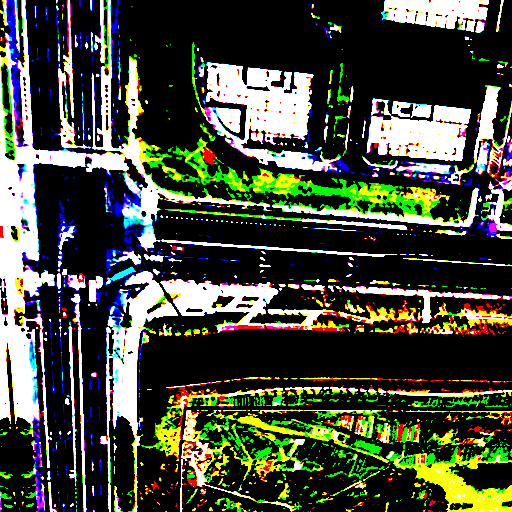

In [14]:
im